# SqueezNet CIFAR-10 

In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.model_zoo as model_zoo

In [0]:
__all__ = ['SqueezeNet', 'squeezenet1_0', 'squeezenet1_1']


In [0]:
model_urls = {
    'squeezenet1_0': 'https://download.pytorch.org/models/squeezenet1_0-a815701f.pth',
    'squeezenet1_1': 'https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth',
}

In [0]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


In [0]:


class SqueezeNet(nn.Module):

    def __init__(self, version=1.0, num_classes=1000):
        super(SqueezeNet, self).__init__()
        if version not in [1.0, 1.1]:
            raise ValueError("Unsupported SqueezeNet version {version}:"
                             "1.0 or 1.1 expected".format(version=version))
        self.num_classes = num_classes
        if version == 1.0:
            self.features = nn.Sequential(
                nn.Conv2d(3, 96,kernel_size=7, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(96, 16, 64, 64),
                Fire(128, 16, 64, 64),
                Fire(128, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 32, 128, 128),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(512, 64, 256, 256),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
        # Final convolution is initialized differently form the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13, stride=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m is final_conv:
                    init.normal(m.weight.data, mean=0.0, std=0.01)
                else:
                    init.kaiming_uniform(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), self.num_classes)

In [0]:
def squeezenet1_0(pretrained=False, **kwargs):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = SqueezeNet(version=1.0, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['squeezenet1_0']))
    return model

In [0]:
seq=squeezenet1_0(pretrained=False,num_classes=10).cuda()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms


transforms.Resize((227,227))

transform = transforms.Compose(
    [transforms.Resize((227,227)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


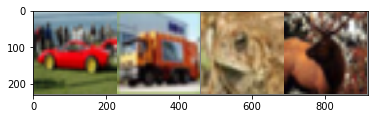

  car truck  frog  deer


In [0]:
import matplotlib.pyplot as plt
import numpy as np
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
images.shape

torch.Size([4, 3, 227, 227])

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(seq.parameters(), lr=0.001, momentum=0.9)

In [0]:
optimizer.zero_grad()


In [0]:
for epoch in range(10):  # loop over the dataset multiple times
    print(epoch)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = seq(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = seq(images.cuda())

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = seq(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

acc=100 * correct / total



Accuracy of the network on the 10000 test images: 67 %


### Number of total parameters

In [0]:
pytorch_total_params = sum(p.numel() for p in seq.parameters())
pytorch_total_params


### Number of trainable parameters

In [0]:
pytorch_train_params = sum(p.numel() for p in seq.parameters() if p.requires_grad)

pytorch_train_params


### Model Summary

In [0]:
# model summary 
import torch.nn.functional as F
from torchsummary import summary
seq.cuda()
summary(seq, (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 111, 111]          14,208
              ReLU-2         [-1, 96, 111, 111]               0
         MaxPool2d-3           [-1, 96, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,552
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

# SqueezNet MINST 

In [0]:
seq2=squeezenet1_0(pretrained=False,num_classes=10).cuda()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [0]:
transform = transforms.Compose(
    [torchvision.transforms.Grayscale(num_output_channels=3),transforms.Resize((227,227)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])


trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

0it [00:00, ?it/s]

9920512it [00:01, 8639264.36it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135803.47it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2450669.01it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51463.93it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


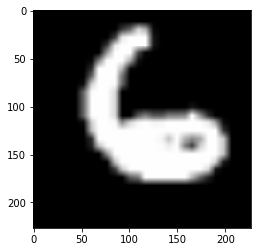

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images=images[0]
labels=labels[0]
# show images
imshow(torchvision.utils.make_grid(images))
# print labels

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(seq2.parameters(), lr=0.001)
optimizer.zero_grad()

In [0]:
for epoch in range(10):  # loop over the dataset multiple times
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = seq2(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
       
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

0
[1,  2000] loss: 2.303
[1,  4000] loss: 2.302
[1,  6000] loss: 2.306
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.305
[1, 14000] loss: 2.304
1
[2,  2000] loss: 2.305
[2,  4000] loss: 2.304
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
[2, 10000] loss: 2.303
[2, 12000] loss: 2.301
[2, 14000] loss: 2.303
2
[3,  2000] loss: 2.304
[3,  4000] loss: 2.304
[3,  6000] loss: 2.304
[3,  8000] loss: 2.302
[3, 10000] loss: 2.303
[3, 12000] loss: 2.303
[3, 14000] loss: 2.305
3
[4,  2000] loss: 2.303
[4,  4000] loss: 2.303
[4,  6000] loss: 2.303
[4,  8000] loss: 2.304
[4, 10000] loss: 2.305
[4, 12000] loss: 2.304
[4, 14000] loss: 2.303
4
[5,  2000] loss: 2.304
[5,  4000] loss: 2.304
[5,  6000] loss: 2.302
[5,  8000] loss: 2.304
[5, 10000] loss: 2.303
[5, 12000] loss: 2.304
[5, 14000] loss: 2.305
5
[6,  2000] loss: 2.304
[6,  4000] loss: 2.304
[6,  6000] loss: 2.304
[6,  8000] loss: 2.304
[6, 10000] loss: 2.302
[6, 12000] loss: 2.302
[6, 14000] loss: 2.304
6
[7,  2000] loss: 2.3

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = seq2(images.cuda())

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = seq2(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

acc=100 * correct / total


In [0]:
# model summary 
import torch.nn.functional as F
from torchsummary import summary
seq2.cuda()
summary(seq2, (3, 227, 227))